# Lab 3: Evaluation of the model

***Author: Martín Cepeda***

## Part 1: Fixing Teaching Forcing

### Beam Search
The original beam-search strategy finds a translation that approximately maximizes the conditional probability given by a specific model. It builds the translation from left-to-right and keeps a fixed number (beam) of translation candidates with the highest log-probability at each time step. For each end-of-sequence symbol that is selected among the highest scoring candidates the beam is reduced by one and the translation is stored into a final candidate list. When the beam is zero, it stops the search and picks the translation with the highest log-probability (normalized by the number of target words) out of the final candidate list[.](https://arxiv.org/pdf/1702.01806.pdf)

**Trade-off:** By setting the beam size large enough, we ensure that the best translation performance can be reached with the drawback that many candidates whose scores are far away from the best are also explored.


### Curriculum Learning (Scheduled Sampling)

At an abstract level, a curriculum can be seen as a sequence of training criteria. Each training criterion in the sequence is associated with a different set of weights on the training examples, or more generally, on a reweighting of the training distribution. Initially, the weights favor “easier” examples, or examples illustrating the simplest concepts, that can be learned most easily. The next training criterion involves a slight change in the weighting of examples that increases the
probability of sampling slightly more difficult examples. At the end of the sequence, the reweighting of the examples is uniform and we train on the target training set or the target training distribution[.](http://machinelearning.org/archive/icml2009/papers/119.pdf)


### Parallel Scheduled Sampling
Scheduled Sampling (Bengio et al., 2015) is a training technique designed to bridge the gap between teacher-forcing and sample decoding. In its simplest form, Sequential Scheduled Sampling generates tokens $\tilde y_{1:t}$ and conditions on these target prefixes during training. Sequential Scheduled Sampling uses the same objective function as teacher-forcing except the conditioning tokens $\tilde y_{1:t}$ are a random mixture of gold tokens $ y_{1:t}$ and sampled tokens $\hat y_{1:t}$ instead of gold tokens $ y_{1:t}$.

Whereas Sequential Scheduled Sampling selects conditioning tokens one after another, Parallel Scheduled Sampling consists on generating conditioning tokens for all timesteps in parallel over the course of one or more passes. While this technique requires strictly more operations than Sequential Scheduled Sampling, it is better suited to hardware accelerators such as GPUs and TPUs. The procedure consists of multiple passes, each pass consisting of parallel sampling and mixing steps[.](https://arxiv.org/pdf/1906.04331.pdf)


### Professor Forcing

The basic idea of Professor Forcing is simple: while we do want the generative RNN to match thetraining data, we also want the behavior of the network (both in its outputs and in the dynamics of its hidden states) to be indistinguishable whether the network is trained with its inputs clamped to a training sequence (teacher forcing mode) or whether its inputs are self-generated (free-running generative mode). Because we can only compare the distribution of these sequences, it makes sense
to take advantage of the generative adversarial networks (GANs) framework to achieve that second objective of matching the two distributions over sequences (the one observed in teacher forcing mode vs the one observed in free-running mode)[.](https://arxiv.org/pdf/1610.09038.pdf)

## Part 2: "Improved" model

This part is mostly qualitative. Whereas I re-implemented the model presented in Lab 2 including attention, the results are more than catastrophic. This is due to several reasons:

a) no real fixing of exposure bias

b) scarce number of training epochs due to limited computing time/power

c) rather small dataset considering that we're trying to accomplish a variant of machine translation

Nevertheless, the sources can also be traced back to feature selection: sampling rate for fundamental frequency, robustness of OpenFace to extract action features or the sufficiency of F0 to explain the different AUs. In [this paper](https://arxiv.org/ftp/arxiv/papers/1810/1810.12541.pdf) they explore a conceptually similar approach but based on text, which has a much richer domain and semantics than the discretization of F0, whereas in [this paper](https://link.springer.com/article/10.1007/s11263-019-01251-8) they leverage visual information (not AUs) to make a GAN speech-to-gesture synthesizer. Again, we observe a bigger feature domain that could ultimately have AUs as a side product once the gesture image is produced. Similarly, in [this paper](https://dl.acm.org/doi/10.1145/3072959.3073658) they explore the use of non-prosodic audio features to learn the 3D mesh extracted from video. Also, they redefine the loss (as they're dealing with points in R^3).


In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras

from pprint import pprint
%matplotlib inline

### Path setup

This section sets the relative paths to:

- Search for clean features
- Set paths for saving model checkpoints and training history

In [2]:
here = os.getcwd()

base_dir = os.path.join(here, "data")
batch1_dir = os.path.join(base_dir, "batch 1")
batch2_dir = os.path.join(base_dir, "batch 2")
figures_dir = os.path.join(here, "figures", "lab3")

debug_dir = os.path.join(here, "debug")
model_dir = os.path.join(debug_dir, "model")
history_dir = os.path.join(debug_dir, "history")

os.makedirs(debug_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

In [3]:
batch1_ids = [os.path.split(file)[1][:-4] for file in glob(os.path.join(batch1_dir, "*.csv"))]
batch2_ids = [os.path.split(file)[1][:-4] for file in glob(os.path.join(batch2_dir, "*.csv"))]

video_ids = batch1_ids + batch2_ids

print("Available videos:")
video_ids

Available videos:


['k4vzhweOefs',
 'lr-mXnUoUXM',
 'O6jrLgvCUNs',
 'ovKqmRyOGcg',
 'psN1DORYYV0',
 'tZYkjaKNr_o',
 'XE_FPEFpHt4',
 'yCm9Ng0bbEQ',
 'zawpbVpu5nY',
 'ZdDjexbxVzM',
 '2tBuvxXxlS4',
 '3boKz0Exros',
 '5RAJvzV9j-o',
 '6LmPq7D-ds0',
 '6OaIdwUdSxE',
 '6We_1bXRBOk',
 'd6NKdnZvdoo',
 'E3cK8IL0JCE',
 'eD9F5HdyKqU',
 'g3vSYbT1Aco',
 'MvXZzKZ3JYQ',
 'NP8xt8o4_5Q',
 'urntcMUJR9M',
 'ux1GxExRUUY',
 'wD3-6JIUF7M',
 'y9ALB39wRKo']

### Loading clean data

In order to make our dataset, we must make windows of size 100 **per each scene** in ell videos. In order to do this, we can merge all video CSVs one unique dataframe and identify all scenes, keeping track of video IDs and frame numbers to recover the correspondant $F0$

In [4]:
# Merge all dataframes
df_AU = pd.DataFrame()

for i, video_id in enumerate(tqdm(video_ids)):
    # Infer directory
    batch_dir_i = batch1_dir if i < len(batch1_ids) else batch2_dir
    # Read video dataframe
    df_i = pd.read_csv(os.path.join(batch_dir_i, f"{video_id}.csv"))
    # Read audio dataframe
    df_f0_i = pd.read_csv(os.path.join(batch_dir_i, f"{video_id}.f0.txt"),
                         sep="\t",
                         names=["timestamp", "f0"])
    
    # Merge on timestamps of AU dataframe
    df_i = pd.merge_asof(df_i, df_f0_i, on="timestamp")
    # Add video id for future tracking
    df_i['video_id'] = video_id
    # Append to total dataframe
    df_AU = df_AU.append(df_i)

df_AU.reset_index(drop=True, inplace=True)
# Drop success column as data is clean
df_AU.drop("success", axis=1, inplace=True)

print("Missing values:")
print(df_AU.isna().sum())

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 14.96it/s]

Missing values:
frame        0
timestamp    0
AU01_r       0
AU02_r       0
AU04_r       0
AU05_r       0
AU06_r       0
AU07_r       0
f0           0
video_id     0
dtype: int64


Scene extraction

In [5]:
def get_scene_idxs(df):
    """Get beginning and end indexes for every scene in dataframe.
    A scene is defined by a series of consecutive frames
    """
    # Get idxs where there are no consecutive frames
    end_of_scenes = list(np.where(df['frame'].diff().bfill() != 1)[0])
    end_of_scenes.append(len(df))
    
    # Fill tuples (frame_beginning, frame_end) for each scene
    scene_idxs = []
    for i, idx in enumerate(end_of_scenes):
        if i == 0:
            beg_i = 0  
        else:
            beg_i = end_of_scenes[i-1]
        
        end_i = idx
        
        scene_idxs.append((beg_i, end_i))
    # Return list of scene indexes
    return scene_idxs

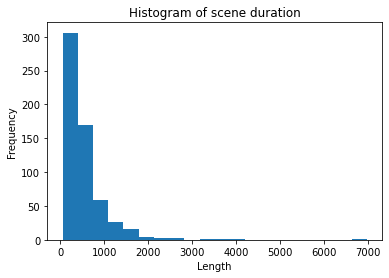

Description of the length of scenes:
count     590.000000
mean      522.869492
std       538.166413
min        51.000000
25%       218.000000
50%       379.500000
75%       628.500000
max      6971.000000
dtype: float64


In [6]:
scene_idxs = get_scene_idxs(df_AU)

# Show and describe scene lengths
scene_lengths = pd.Series([id_f - id_i for (id_i, id_f) in scene_idxs])

plt.hist(scene_lengths, bins=20)
plt.title("Histogram of scene duration")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.savefig(os.path.join(figures_dir, "scene_hist.png"), bbox_inches='tight', facecolor="white",transparent=False)
plt.show()

print("Description of the length of scenes:")
print(scene_lengths.describe())

In [7]:
# Sanity check: all scenes span always an unique video
for (id_i, id_f) in scene_idxs:
    if df_AU[id_i:id_f]['video_id'].nunique() != 1:
        print(f"Problem in scene between {id_i} and {id_f}")

### Make sequence dataset

We define a quantization function for AU intensity following the formula:
$$Q_\Delta(x) = \Delta\cdot\left \lfloor{\frac{x}{\Delta}+\frac{1}{2}}\right \rfloor $$

Which rounds $x$ to the nearest multiple of $\Delta$

In [8]:
def quantize(x, step=0.1):
    """Quantize a scalar or a numpy array with a fixed step size
    """
    assert step > 0.0
    return np.round(step*np.floor(x/step +0.5), 1)

Quantization parameters for AU and F0, sequence parameters

In [9]:
STEP_SIZE_AU = 0.2
STEP_SIZE_F0 = 0.1

Perform quantization on AU and F0, also clipping the latter between 50 and 550

In [10]:
AU_columns = [col for col in df_AU.columns if "AU" in col]

df_AU[AU_columns] = df_AU[AU_columns].applymap(lambda x: quantize(x, STEP_SIZE_AU))
df_AU["f0"] = df_AU["f0"].apply(lambda x: quantize(np.clip(x, 50, 550), STEP_SIZE_F0))

Make vocabularies

In [11]:
all_AU = set()
for col in AU_columns:
    all_AU = all_AU.union(df_AU[col].values)
    
ID_to_AU = {0: "PAD",
            1: "SOS",
            2: "EOS"}
for i, value in enumerate(sorted(list(all_AU))):
    ID_to_AU[i+3] = str(value)
    
all_f0 = set(df_AU["f0"].values)
ID_to_F0 = {0: "PAD",
            1: "SOS",
            2: "EOS"}
for i, value in enumerate(sorted(list(all_f0))):
    ID_to_F0[i+3] = str(value)

# Make reverse_search dictionaries
AU_to_ID = {v:k for k, v in ID_to_AU.items()}
F0_to_ID = {v:k for k, v in ID_to_F0.items()}


print("Vocabulary sizes")
print(f"AU: {len(all_AU)}")
print(f"F0: {len(all_f0)}")

Vocabulary sizes
AU: 26
F0: 3605


Make sequences of 100 frames

Sequences are made with string values to avoid float issues comparing numbers and mixing numerical values with tags such as "PAD"

In [12]:
SEQ_LEN = 100
SEQ_OVERLAP = 2 # At least 2 sample overlap as we introduce SOS and EOS tokens for each sequence

In [13]:
sequences_features = []
sequences_predict = []

# Create sequences independantly for every scene
# Each sequence is made of indexes (translate after with ID_to_X)
for i, (idscene_i, idscene_f) in enumerate(tqdm(scene_idxs)):
    l = idscene_f - idscene_i
    current_i = idscene_i
    
#     print("scene", current_i, idscene_f)
    # While possible to fit a whole sequence of SEQ_LEN, do it
    while current_i + SEQ_LEN <= idscene_f:
        # Sequence limits
        id_i = current_i
        id_f = current_i + SEQ_LEN
        # Update current i
        current_i = current_i + SEQ_LEN - SEQ_OVERLAP
        
        # Get data F0
        seq_feature = np.array([F0_to_ID[str(i)] for i in df_AU[id_i:id_f]["f0"].values], dtype=int)
        seq_predict = np.zeros((SEQ_LEN, len(AU_columns)), dtype=int)
        # Get data AUs
        predict_values = df_AU[id_i:id_f][AU_columns].values
        for i in range(predict_values.shape[0]):
            for j in range(predict_values.shape[1]):
                seq_predict[i, j] = AU_to_ID[str(predict_values[i, j])]
                
        # Add SOS-EOS indexes
        # SOS
        seq_feature[0] = 1
        seq_predict[0,:] = 1
        # EOS
        seq_feature[SEQ_LEN-1] = 2
        seq_predict[SEQ_LEN-1,:] = 2
        
        # Save sequence
        sequences_features.append(seq_feature)
        sequences_predict.append(seq_predict)
#         print("--> added", id_i, id_f)
        
    # Handle last window with padding
    if current_i != idscene_f - SEQ_OVERLAP:
        last_frame_features = np.zeros((SEQ_LEN), dtype=int)
        last_frame_predict = np.zeros((SEQ_LEN, len(AU_columns)), dtype=int)
        # Get data F0
        last_frame_features[:idscene_i+l-current_i] = np.array(
            [F0_to_ID[str(i)] for i in df_AU[current_i:idscene_f]["f0"].values], 
                                                               dtype=int)
        # Get data AUs
        predict_values = df_AU[current_i:idscene_f][AU_columns].values
        for i in range(predict_values.shape[0]):
            for j in range(predict_values.shape[1]):
                last_frame_predict[i, j] = AU_to_ID[str(predict_values[i, j])]        
        
        # Add SOS-EOS indexes
        # SOS
        last_frame_features[0] = 1
        last_frame_predict[0,:] = 1
        # EOS
        last_frame_features[predict_values.shape[0]] = 2
        last_frame_predict[predict_values.shape[0],:] = 2
        
        # Save sequence
        sequences_features.append(last_frame_features)
        sequences_predict.append(last_frame_predict)

sequences_indexes = list(range(len(sequences_features)))
sequences_features = np.array(sequences_features)
sequences_predict = np.array(sequences_predict)

100%|███████████████████████████████████████████████████████████████████████████████| 590/590 [00:03<00:00, 161.73it/s]


In [14]:
print(f"Using sequences of length {SEQ_LEN} with {SEQ_OVERLAP} overlapping samples")
print("Input features shape", sequences_features.shape)
print("Target features shape", sequences_predict.shape)

Using sequences of length 100 with 2 overlapping samples
Input features shape (3430, 100)
Target features shape (3430, 100, 6)


### Make Train/Val/Test split

In [15]:
def seq_to_onehot(sequence):
    """Trasnforms a sequence of indexes to a one-hot encoding of the same sequence. 
    Output array has 1 extra dimension of the size of the vocabulary
    """
    # Infer output size from F0 or AU
    if len(sequence.shape) == 1:
        new_sequence = np.zeros((sequence.shape[0], len(F0_to_ID)))
    else:
        new_sequence = np.zeros((sequence.shape[0], sequence.shape[1], len(AU_to_ID)))
    # Fill one-hot vectors
    for i in range(sequence.shape[0]):
        if len(sequence.shape) == 1:
            sample_i = sequence[i]
            new_sequence[i, sample_i] = 1.0
        else:
            for j in range(sequence.shape[1]):
                sample_ij = sequence[i,j]
                new_sequence[i, j, sample_ij] = 1.0
    
    return new_sequence

def onehot_to_seq(onehot):
    """Transforms a one-hot encoding of an index array to an index array.
    Output array has 1 less dimension
    """
    # Infer output size from F0 or AU, return argmax to have index of one-hot
    if len(onehot.shape) == 2:
        return np.argmax(onehot, axis=1)
    else:
        return np.array([np.argmax(onehot_i, axis=1) for onehot_i in onehot])
    
def seq_to_real(sequence):
    """ Returns the corresponding quantized values from a sequence of vocabulary indexes.
    As there are no negative values in data, the following convention is used:
     0: PAD
    -1: SOS
    -2: EOS
    """
    # Create containing array
    values = np.zeros_like(sequence, dtype=float)
    # Fill array (F0 case)
    if len(sequence.shape) == 1:
        for i, s_i in enumerate(sequence):
            val_i = ID_to_F0[s_i]
            if val_i not in ["PAD", "SOS", "EOS"]:
                values[i] = float(val_i)
            else:
                values[i] = -s_i
    # Fill array (AUs case)
    else:
        for i in range(sequence.shape[0]):
            for j in range(sequence.shape[1]):
                val_ij = ID_to_AU[sequence[i, j]]
                if val_ij not in ["PAD", "SOS", "EOS"]:
                    values[i, j] = float(val_ij)
                else:
                    values[i, j] = -sequence[i, j]
    return values

In [16]:
# Sanity check
for i, s in enumerate(tqdm(sequences_features)):
    assert (s - onehot_to_seq(seq_to_onehot(s)) == np.zeros_like(s)).all(), i

for i, s in enumerate(tqdm(sequences_predict)):
    assert (s - onehot_to_seq(seq_to_onehot(s)) == np.zeros_like(s)).all(), i

100%|████████████████████████████████████████████████████████████████████████████| 3430/3430 [00:01<00:00, 2109.47it/s]


### seq2seq model

For this Lab we'll work only with F0 as feature and we'll try to predict the Action units.

Each sequence is starts with `SOS` and ends with `EOS`, eventually with `PAD`. The code of this section is inspired from [this tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention)

Dataset:

In [52]:
BUFFER_SIZE = len(sequences_features)
BATCH_SIZE = 15
embedding_dim = 256
units = 1024
vocab_inp_size = len(F0_to_ID)
vocab_tar_size = len(AU_to_ID)

AU_model = 0

train_size = int(0.8 * BUFFER_SIZE)
val_size = int(0.1 * BUFFER_SIZE)
test_size = int(0.1 * BUFFER_SIZE)

dataset = tf.data.Dataset.from_tensor_slices((sequences_features, sequences_predict[:, :, AU_model])).shuffle(BUFFER_SIZE)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)



train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [53]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([15, 100]), TensorShape([15, 100]))

In [54]:
example_input_batch, example_target_batch = next(iter(val_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([15, 100]), TensorShape([15, 100]))

In [55]:
example_input_batch, example_target_batch = next(iter(test_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([15, 100]), TensorShape([15, 100]))

Define model modules

In [56]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
    
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [57]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (15, 100, 1024)
Encoder Hidden state shape: (batch size, units) (15, 1024)


In [58]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (15, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (15, 100, 1)


In [59]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (15, 29)


In [60]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Train function

In [62]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([AU_to_ID['SOS']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss





In [63]:
@tf.function
def validation_step(inp, targ, enc_hidden):
    loss = 0

    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([AU_to_ID['SOS']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    return batch_loss

In [65]:
losses_train = []
losses_val = []
EPOCHS = 5

steps_per_epoch_train = train_dataset.cardinality().numpy()//BATCH_SIZE
steps_per_epoch_val = val_dataset.cardinality().numpy()//BATCH_SIZE

for epoch in tqdm(range(EPOCHS)):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in tqdm(enumerate(train_dataset.take(steps_per_epoch_train))):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        losses_train.append(batch_loss)

        if batch % 20 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # Validation:
    for (batch, (inp, targ)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val))):
        batch_val_loss = validation_step(inp, targ, enc_hidden)
        losses_val.append(batch_val_loss)
        
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch_train))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:09,  9.38s/it]

Epoch 1 Batch 0 Loss 2.9627



2it [00:18,  9.20s/it]
3it [00:27,  9.16s/it]
4it [00:36,  9.20s/it]
5it [00:46,  9.25s/it]
6it [00:55,  9.31s/it]
7it [01:05,  9.40s/it]
8it [01:15,  9.58s/it]
9it [01:24,  9.54s/it]
10it [01:34,  9.53s/it]
11it [01:43,  9.48s/it]
12it [01:52,  9.42s/it]

0it [00:00, ?it/s]
1it [00:02,  2.91s/it]
 20%|████████████████▌                                                                  | 1/5 [01:55<07:43, 115.91s/it]
0it [00:00, ?it/s]

Epoch 1 Loss 3.7407
Time taken for 1 epoch 115.91215395927429 sec




1it [00:09,  9.58s/it]

Epoch 2 Batch 0 Loss 1.1815



2it [00:19,  9.79s/it]
3it [00:29,  9.93s/it]
4it [00:39,  9.79s/it]
5it [00:48,  9.62s/it]
6it [00:57,  9.55s/it]
7it [01:07,  9.57s/it]
8it [01:16,  9.47s/it]
9it [01:26,  9.50s/it]
10it [01:35,  9.43s/it]
11it [01:45,  9.44s/it]
12it [01:54,  9.55s/it]

0it [00:00, ?it/s]
1it [00:02,  2.93s/it]
 40%|█████████████████████████████████▏                                                 | 2/5 [03:53<05:51, 117.09s/it]
0it [00:00, ?it/s]

Epoch 2 Loss 1.3693
Time taken for 1 epoch 117.92104768753052 sec




1it [00:09,  9.31s/it]

Epoch 3 Batch 0 Loss 1.2824



2it [00:18,  9.36s/it]
3it [00:28,  9.40s/it]
4it [00:37,  9.43s/it]
5it [00:47,  9.55s/it]
6it [00:56,  9.46s/it]
7it [01:05,  9.40s/it]
8it [01:15,  9.59s/it]
9it [01:25,  9.53s/it]
10it [01:34,  9.53s/it]
11it [01:44,  9.51s/it]
12it [01:53,  9.48s/it]

0it [00:00, ?it/s]
1it [00:02,  2.93s/it]
 60%|█████████████████████████████████████████████████▊                                 | 3/5 [05:50<03:53, 116.93s/it]
0it [00:00, ?it/s]

Epoch 3 Loss 1.0739
Time taken for 1 epoch 116.74099969863892 sec




1it [00:09,  9.29s/it]

Epoch 4 Batch 0 Loss 1.1308



2it [00:18,  9.26s/it]
3it [00:28,  9.36s/it]
4it [00:37,  9.53s/it]
5it [00:47,  9.69s/it]
6it [00:57,  9.67s/it]
7it [01:07,  9.78s/it]
8it [01:17,  9.79s/it]
9it [01:26,  9.76s/it]
10it [01:36,  9.80s/it]
11it [01:46,  9.72s/it]
12it [01:55,  9.66s/it]

0it [00:00, ?it/s]
1it [00:02,  2.98s/it]
 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:49<01:57, 117.88s/it]
0it [00:00, ?it/s]

Epoch 4 Loss 1.0293
Time taken for 1 epoch 119.33600044250488 sec




1it [00:09,  9.37s/it]

Epoch 5 Batch 0 Loss 0.9279



2it [00:18,  9.34s/it]
3it [00:28,  9.33s/it]
4it [00:37,  9.45s/it]
5it [00:47,  9.43s/it]
6it [00:56,  9.51s/it]
7it [01:06,  9.68s/it]
8it [01:16,  9.84s/it]
9it [01:26,  9.78s/it]
10it [01:36,  9.77s/it]
11it [01:45,  9.66s/it]
12it [01:55,  9.60s/it]

0it [00:00, ?it/s]
1it [00:02,  2.96s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:48<00:00, 117.63s/it]

Epoch 5 Loss 0.8654
Time taken for 1 epoch 118.21458959579468 sec



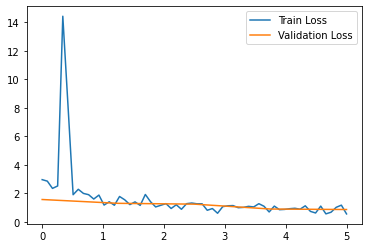

In [68]:
t_train = np.linspace(0, EPOCHS, len(losses_train))
t_val = np.linspace(0, EPOCHS, len(losses_val))

plt.plot(t_train, losses_train, label='Train Loss')
plt.plot(t_val, losses_val, label='Validation Loss')
plt.legend()
plt.show()

In [74]:
def evaluate(sequence):
    max_length_targ = 100
    max_length_inp = 100
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = sequence
    result = np.zeros(max_length_targ, dtype=int)

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([AU_to_ID['SOS']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result[t] = predicted_id

        if ID_to_AU[predicted_id] == 'EOS':
            return result, sentence, attention_plot

    # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [100]:
@tf.function
def evaluation_step(inp, targ, enc_hidden):
    loss = 0
    
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([AU_to_ID['SOS']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    preds = np.zeros_like(inp)
    for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        preds[:,t] = predicted_id

    batch_loss = (loss / int(targ.shape[1]))

    return batch_loss, preds

In [102]:
steps_per_epoch_test = test_dataset.cardinality().numpy()//BATCH_SIZE


enc_hidden = encoder.initialize_hidden_state()
total_loss = 0

predictions = []
for (batch, (inp, targ)) in tqdm(enumerate(test_dataset.take(steps_per_epoch_test))):
    batch_loss_test, preds = evaluation_step(inp, targ, enc_hidden)
    total_loss += batch_loss_test
    predictions.append(preds)

1it [00:02,  2.87s/it]


In [103]:
print(f'Test loss {total_loss}')

Test loss 1.698737382888794


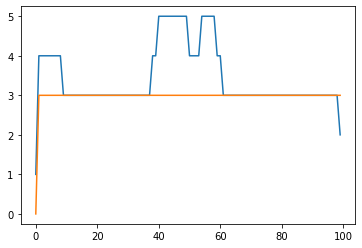

In [109]:
plt.plot(targ[2])
plt.plot(preds[2])